## 1. GAN.

GAN (Generative Adversarial Network) - семейство моделей, которые выучивают распределение над данными соревнованием (adversarial=состязание) двух нейронных сетей:

1. Дискриминатор пытается отличить сгенерированные объекты от реальных.
2. Генератор пытается обмануть дискриминатор и сгенерировать такие объекты, которые он не сможет отличить от настоящих.

Задача, которую решают сети, является минимаксной (одна сеть пытается минимизировать функционал, а другая максимизировать) и её точка равновесия достигается, когда генератор выдает объекты, полностью не отличимые от настоящих.


In [1]:
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

from IPython.display import clear_output

device = 'cpu'

/Users/binom/.anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Vanilla GAN.

Для Vanilla GAN функционал имеет следующий вид:

$L(D, G) = - \frac1n \sum_{x_i \in X} \log D(x_i) - \frac1n \sum_{z_i \in N(0, 1)} \log (1 - D(G(z_i))) \rightarrow \min_{D} \max_{G}$

На практике, дискриминатор и генератор обучают не одновременно, а чередуют $n$ шагов оптимизации _только_ генератора и $m$ шагов оптимизации _только_ дискриминатора. При этом, эмпирически получается лучше, когда дискриминатор обучается больше шагов, чем генератор. $n$ и $m$ являются гиперпараметрами и подбираются под задачу архитектуры генератора и дискриминатора.

Процесс обучения GAN'а можно описать следующим кодом.

In [2]:
from typing import Optional
from typing_extensions import Literal

def gan_loss(real_objects_scores: torch.Tensor,
             generated_objects_scores: torch.Tensor, 
             by: Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
  '''
  Имплементирует подсчет лосса для генератора и дискриминатора.
  '''
  criterion = nn.BCEWithLogitsLoss()

  if by=='generator':
    # возвращает лосс генератора
    return criterion(generated_objects_scores, torch.ones_like(generated_objects_scores)).mean()
  elif by == 'discriminator':
    # возвращает лосс дискриминатора
    return criterion(generated_objects_scores, torch.zeros_like(generated_objects_scores)).mean() + criterion(real_objects_scores, torch.ones_like(real_objects_scores)).mean()

def get_energy_vanilla_gan(z, prior, gen, discr):
  return -discr(gen(z)).squeeze() -prior_mnist.log_prob(z)

def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt,
              loss_func, prior,
              num_epochs, gen_steps, discr_steps,
              energy_func=None,
              discr_params_clip_value=None,
              verbose_num_iters=100,
              data_type='2d'):
    '''
    Имплементирует подсчет лосса для генератора и дискриминатора.
    '''
    gen.train()
    discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # берем реальные объекты
            real_objects, y = batch
            real_objects = real_objects.to(device)
            y = y.to(device)
            
            # генерируем новые объекты
            num_objects = real_objects.shape[0]
            z = prior.sample((num_objects, ))
            gen_objects = gen(z, y)
            
            # считаем скоры
            real_objects_scores, gen_objects_scores = torch.split(discr(
                torch.cat([real_objects, gen_objects], dim=0), 
                torch.cat([y, y], dim=0)), num_objects)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
              # делаем шаг обучения генератора
              gen_opt.zero_grad()
              gen_loss = loss_func(real_objects_scores, gen_objects_scores, 'generator')
              gen_loss.backward()
              gen_opt.step()
              gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
              # делаем шаг обучения дискриминатора
              discr_opt.zero_grad()
              discr_loss = loss_func(real_objects_scores, gen_objects_scores, 'discriminator')
              discr_loss.backward()
              discr_opt.step()
              discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(40, 10))
                
                plt.subplot(1, 4, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 4, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')
                    
                gen.eval()
                discr.eval()
                if data_type == 'mnist':
                  with torch.no_grad():
                    z = prior.sample((100, ))
                    sampled_mnist = gen(z, torch.arange(100).to(device) % 10)

                  for i in range(100):
                    plt.subplot(10, 40, 40 * (i // 10) + 21 + (i % 10))
                    plt.axis('off')
                    plt.imshow((sampled_mnist[i, 0].detach().cpu().numpy() + 1) / 2, cmap='gray')
                    
                  # make grid
                  if energy_func is not None:
                    plt.subplot(1, 4, 4)
                    steps = 50

                    batch_size = 64

                    grid = np.meshgrid(np.linspace(-1, 1, steps), np.linspace(-1, 1, steps))
                    grid = np.concatenate([c.reshape(-1, 1) for c in grid], axis=-1)

                    energy_values = []
                    for i in range(grid.shape[0] // batch_size + (1 if grid.shape[0] % batch_size else 0)):
                      z = torch.FloatTensor(grid[i * batch_size: (i + 1) * batch_size]).to(device)
                      energy_values.append(energy_func(z, prior_mnist, gen_mnist, discr_mnist).detach().cpu().numpy())

                    energy_values = np.concatenate(energy_values)

                    seaborn.heatmap(energy_values.reshape(steps, steps), cmap="YlGnBu")

                plt.show()
                gen.train()
                discr.train()
                
    gen.eval()
    discr.eval()

### GAN на картинках.

Теперь давайте попробуем обучить GAN на данных посложнее - на картинках из датасета MNIST.

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class GeneratorMNIST(nn.Module):
    def __init__(self, lat_size):
        super(GeneratorMNIST, self).__init__()

        img_size=28
        
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(
            nn.Linear(lat_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128 * self.init_size ** 2)
        )

        self.conv_blocks = nn.Sequential(
            #nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            #nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            #nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, foo=None):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class DiscriminatorMNIST(nn.Module):
    def __init__(self):
        super(DiscriminatorMNIST, self).__init__()

        img_size = 28
        
        def discriminator_block(in_filters, out_filters, bn=False):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2), nn.Dropout2d(0.0)]
            #if bn:
            #    block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1))

    def forward(self, img, foo=None):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [4]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [17]:
gen_mnist = GeneratorMNIST(2)
gen_mnist.to(device)

discr_mnist = DiscriminatorMNIST()
discr_mnist.to(device)

gen_mnist.apply(weights_init_normal)
discr_mnist.apply(weights_init_normal)

prior_mnist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

gen_opt_mnist = optim.Adam(gen_mnist.parameters(), lr=2e-4, betas=(0.5, 0.999))
discr_opt_mnist = optim.Adam(discr_mnist.parameters(), lr=2e-4 , betas=(0.5, 0.999))

In [7]:
gen_params = {k: v for k, v in torch.load('vanilla_gan_2d.ckpt')[0].items() if 'l1.0' not in k}
#print(gen_params['net.0.weight'])
#gen_params['net.0.weight'] = gen_params['net.0.weight'] @ torch.randn(8, 2)
#print(gen_params['net.0.weight'])
gen_mnist.load_state_dict(gen_params, strict=False)
discr_mnist.load_state_dict(torch.load('vanilla_gan_2d.ckpt')[1], strict=False)
gen_mnist.eval()
discr_mnist.eval()

DiscriminatorMNIST(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout2d(p=0.0, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout2d(p=0.0, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout2d(p=0.0, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout2d(p=0.0, inplace=False)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [18]:
discr_mnist(gen_mnist(torch.randn(10, 2)))

tensor([[-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254],
        [-0.0254]], grad_fn=<AddmmBackward0>)

In [19]:
def get_energy_vanilla_gan(z, prior, gen, discr):
  return -discr(gen(z)).squeeze() -prior_mnist.log_prob(z)

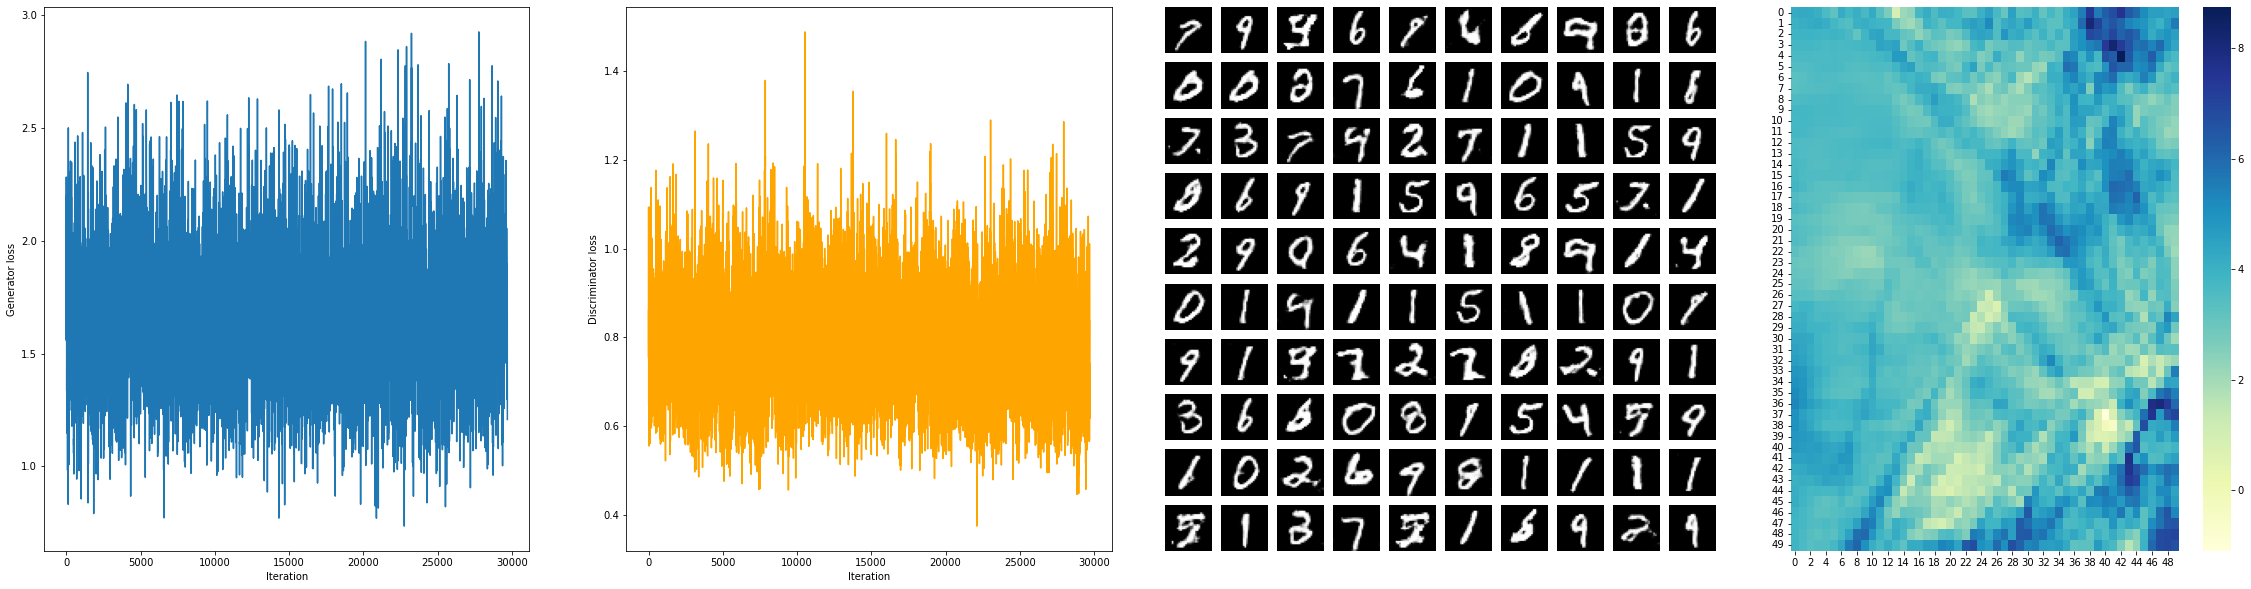

In [ ]:
train_gan(trainloader_mnist, gen_mnist, 
          discr_mnist, gen_opt_mnist, discr_opt_mnist, 
          gan_loss, prior_mnist,
          energy_func=get_energy_vanilla_gan,
          num_epochs=500, gen_steps=1, discr_steps=3,
          verbose_num_iters=100, data_type='mnist')

In [25]:
1

1

In [26]:
1

1

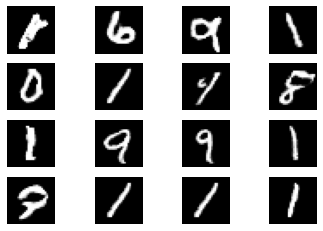

In [27]:
z = prior_mnist.sample((16, ))

sampled_mnist = gen_mnist(z)

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

In [28]:
torch.save((gen_mnist.state_dict(), discr_mnist.state_dict()), 'vanilla_gan_2d.ckpt')

In [29]:
gen_mnist.load_state_dict(torch.load('vanilla_gan_2d.ckpt')[0])
discr_mnist.load_state_dict(torch.load('vanilla_gan_2d.ckpt')[1])
gen_mnist.eval()
discr_mnist.eval()

DiscriminatorMNIST(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout2d(p=0.0, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout2d(p=0.0, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout2d(p=0.0, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout2d(p=0.0, inplace=False)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
)

Для полного обучения Vanilla GAN на MNIST требуется довольно много времени (более 200 эпох), но уже после 20 эпох сгенерированные картинки становятся похожими на реальные объекты, хоть и немного шумными.

In [15]:
z = prior_mnist.sample((16, ))
prior_mnist.log_prob(z).shape

torch.Size([16])

In [16]:
def get_energy_vanilla_gan(z, prior, gen, discr):
  return -discr(gen(z)).squeeze() -prior_mnist.log_prob(z)

In [21]:
# make grid
steps = 100

grid = np.meshgrid(np.linspace(-1, 1, steps), np.linspace(-1, 1, steps))
grid = np.concatenate([c.reshape(-1, 1) for c in grid], axis=-1)

<AxesSubplot:>

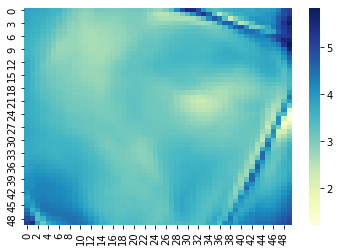

In [27]:
# make grid
steps = 50

batch_size = 64

grid = np.meshgrid(np.linspace(-1, 1, steps), np.linspace(-1, 1, steps))
grid = np.concatenate([c.reshape(-1, 1) for c in grid], axis=-1)

energy_values = []
for i in range(grid.shape[0] // batch_size + (1 if grid.shape[0] % batch_size else 0)):
  z = torch.FloatTensor(grid[i * batch_size: (i + 1) * batch_size]).to(device)
  energy_values.append(get_energy_vanilla_gan(z, prior_mnist, gen_mnist, discr_mnist).detach().cpu().numpy())

energy_values = np.concatenate(energy_values)

seaborn.heatmap(energy_values.reshape(steps, steps), cmap="YlGnBu")

In [23]:
energy_values.shape

(10000,)

<AxesSubplot:>

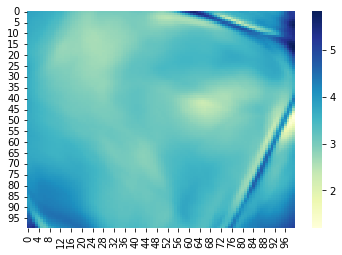

In [24]:
import seaborn

seaborn.heatmap(energy_values.reshape(steps, steps), cmap="YlGnBu")

## 3. WGAN.

Проблема долгого и нестабильного обучения Vanilla GAN кроется в том функционале (и соответсвенно ограничении на выход дискриминатора), который он оптимизирует - когда значения дискриминатора близки к $0$ и $1$, градиент через сигмоиду дискриминатора идет довольно малый.

Благо, как оказалось, мы можем поменять функционал и вместо логаритма от сигмоиды использовать другой, более удобный для оптимизации.

Авторы WGAN предложили оптимизировать следующую функцию и убрать ограничение на выход дискриминатора:

$L(D, G) = - \frac1n \sum_{x_i \in X} D(x_i) + \frac1n \sum_{z_i \in N(0, 1)} D(G(z_i)) \rightarrow \min_{D} \max_{G}$

Однако, цена такого подхода - в необходимости поддерживать константу Липшица у дискриминатора. Самый простой способ это сделать - производить клиппинг (обрезка снизу и сверху) весов дискриминатора.

In [9]:
def wgan_loss(real_objects_scores: torch.Tensor,
             generated_objects_scores: torch.Tensor, 
             by: Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
  '''
  Имплементирует подсчет лосса для генератора и дискриминатора WGAN.
  '''
  if by=='generator':
    # возвращает лосс генератора
    return -generated_objects_scores.mean()
  elif by == 'discriminator':
    # return discriminator loss
    return generated_objects_scores.mean() - real_objects_scores.mean()

In [71]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class GeneratorMNISTWGAN(nn.Module):
    def __init__(self, lat_size):
        super(GeneratorMNISTWGAN, self).__init__()

        img_size=28
        
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(
            nn.Linear(lat_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128 * self.init_size ** 2)
        )

        self.conv_blocks = nn.Sequential(
            #nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            #nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            #nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, foo=None):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class DiscriminatorMNISTWGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorMNISTWGAN, self).__init__()

        img_size = 28
        
        def discriminator_block(in_filters, out_filters, bn=False):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2), nn.Dropout2d(0.0)]
            #if bn:
            #    block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1, bias=False))

    def forward(self, img, foo=None):
        for p in self.parameters():
           p.data.clamp_(-0.06, 0.06)
        
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [72]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [73]:
gen_mnist = GeneratorMNISTWGAN(2)
gen_mnist.to(device)

discr_mnist = DiscriminatorMNISTWGAN()
discr_mnist.to(device)

gen_mnist.apply(weights_init_normal)
discr_mnist.apply(weights_init_normal)

prior_mnist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

gen_opt_mnist = optim.RMSprop(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.RMSprop(discr_mnist.parameters(), lr=3e-4)

In [74]:
gen_params = {k: v for k, v in torch.load('wgan_2d.ckpt')[0].items()}
#print(gen_params['net.0.weight'])
#gen_params['net.0.weight'] = gen_params['net.0.weight'] @ torch.randn(8, 2)
#print(gen_params['net.0.weight'])
gen_mnist.load_state_dict(gen_params, strict=False)
discr_mnist.load_state_dict(torch.load('wgan_2d.ckpt')[1], strict=False)
#gen_mnist.eval()
#discr_mnist.eval()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['adv_layer.0.bias'])

In [75]:
def get_energy_wgan(z, prior, gen, discr):
  return - discr(gen(z)).squeeze() -prior_mnist.log_prob(z)

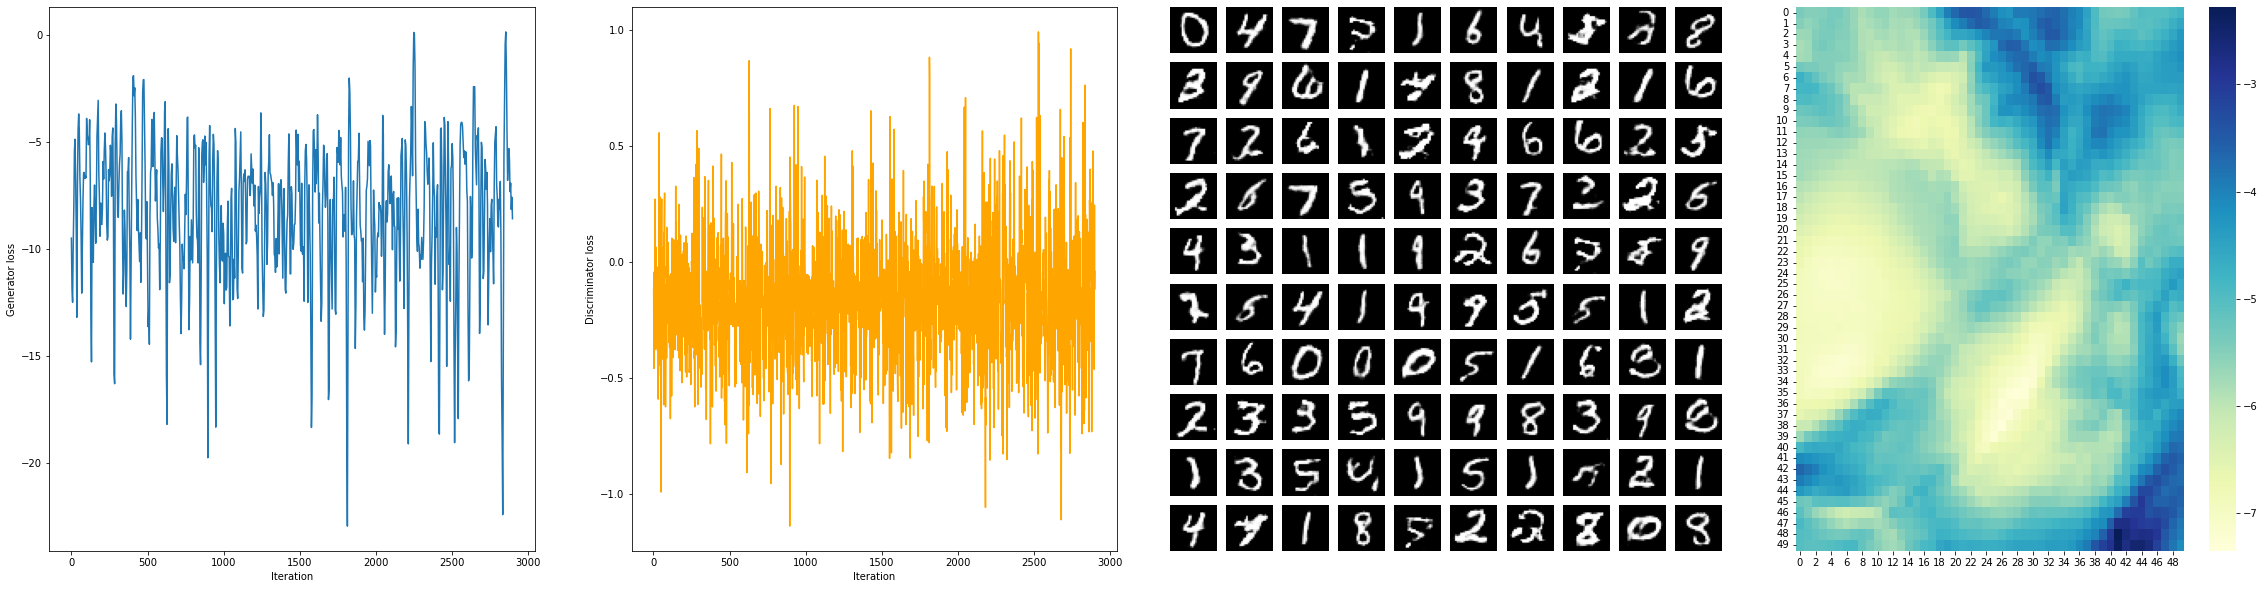

KeyboardInterrupt: 

In [79]:
train_gan(trainloader_mnist, gen_mnist, 
          discr_mnist, gen_opt_mnist, discr_opt_mnist, 
          wgan_loss, prior_mnist,
          energy_func=get_energy_wgan,
          num_epochs=500, 
          gen_steps=1, discr_steps=3,
          verbose_num_iters=100, 
          data_type='mnist')

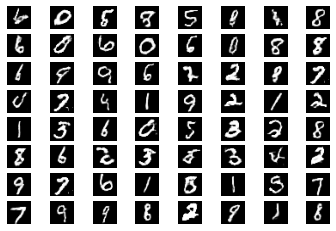

In [80]:
z = prior_mnist.sample((64, ))

sampled_mnist = gen_mnist(z)

for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

Как и в случае с обычным GAN, ждать полного схождения обучения довольно долго, хотя ускорение и стабильность видна невооруженным глазом. Приятные глазу результаты достигаются уже через 80 эпох.

In [81]:
torch.save((gen_mnist.state_dict(), discr_mnist.state_dict()), 'wgan_2d.ckpt')

In [82]:
gen_mnist.load_state_dict(torch.load('wgan_2d.ckpt')[0])
discr_mnist.load_state_dict(torch.load('wgan_2d.ckpt')[1])
gen_mnist.eval()
discr_mnist.eval()

DiscriminatorMNISTWGAN(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout2d(p=0.0, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout2d(p=0.0, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout2d(p=0.0, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout2d(p=0.0, inplace=False)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=False)
  )
)

In [13]:
# make grid
steps = 100

grid = np.meshgrid(np.linspace(-1, 1, steps), np.linspace(-1, 1, steps))
grid = np.concatenate([c.reshape(-1, 1) for c in grid], axis=-1)

In [14]:
batch_size = 64

energy_values = []
for i in range(grid.shape[0] // batch_size + (1 if grid.shape[0] % batch_size else 0)):
  z = torch.FloatTensor(grid[i * batch_size: (i + 1) * batch_size]).to(device)
  energy_values.append(get_energy_wgan(z, prior_mnist, gen_mnist, discr_mnist).detach().cpu().numpy())

energy_values = np.concatenate(energy_values)

In [15]:
energy_values

array([-42.969997, -43.44362 , -43.978874, ..., -40.77986 , -40.713703,
       -40.712326], dtype=float32)

<AxesSubplot:>

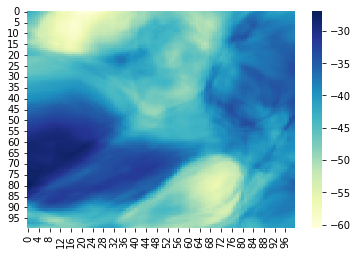

In [16]:
import seaborn

seaborn.heatmap(energy_values.reshape(steps, steps), cmap="YlGnBu")